# Setup

In [2]:
# this notebook requires TF 2.3, check the tf version
# on SWAN at CERN, this requires the bleeding edge stack (as of 17 Dec 2020)
import tensorflow as tf

print(f"TensorFlow {tf.__version__}")

TensorFlow 2.3.0


In [3]:
# load custom css to make plots centered
from IPython.core.display import HTML

css_file = "assets/notebook_styles.css"
HTML(f"<style>{open(css_file, 'r').read()}</style>")

# Background

## Jet classification

This example tries to distinguish between jets produced by a hadronically decaying top quark which hadronizes, to jets produced by a light flavour quark or a gluon.

If the top quark has a very high transverse momentum, the decay products of the top (one b jet and two quark jets stemming from the decaying W boson), will be merged into one single large jet, which is referred to as a **top jet**. Potentially, this jet can exhibit three distinct, resolvable *sub jets*, whereas a light quark or gluon jet only appears as one single, large jet without any significant substructure.

The different appearance of these jets can be used as a handle to discriminate between them. Being able to correctly identify top jets, and tell them apart from the overwhelming background of other light-flavored jets, is extremely important for many reasons.

Since the top quark is so heavy, being the only fermion we know of with a mass on the order of the weak scale, several extensions of the Standard Model which attempt to solve the hierarchy problem predict large couplings of new, hitherto unobserved particles to top quarks. Weeding top quark jets out of the ocean of other jets is therefore crucial for many **New Physics** searches!


## Input data

The input data consists of 1 million jets, originating from either
  - hadronically decaying top quarks (**signal**), or
  - dijet QCD events (**background**),
 
and clustered using the $k_{T}$ algorithm with $\Delta R$ = 0.8.

Data was generated using Phythia & Delphes, configured
  - to collide protons at 14 TeV center-of-mass energy,
  - to generate jets with a $p_{T}$ range of [550, 650] GeV (before hadronization), and
  - **without** mixing in pileup events for simplicity.
  
The data is stored in NumPy arrays across several files, with 50k jets per file.

- 20 training files (`"train"`)
- 8 validation files (`"valid"`)
- 8 testing files (`"test"`)


## Features

Per jet, the four-vectors of up to **200** of its *constituents* are given (800 features). Note that not all jets have that many constituents. To avoid the trouble of working with uneven (so-called *jagged*) arrays, these "missing" constituents vectors are filled with zeros.


## Training targets

Per jet, a flag is given that marks the true origin of the jet 
  - `1` for jets from top quark decays
  - `0` for light jets from QCD events

# Preparations

In [16]:
# load software and helpers
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from helpers import load_data

In [22]:
import helpers
from importlib import reload  
reload(helpers)
from helpers import load_data

In [23]:
# load the content of two "train" files
vectors, labels = load_data("train", start_file=0, stop_file=2)
vectors.shape, labels.shape

((100000, 200, 4), (100000,))

In [24]:
# define some flags to make four-vector element access more verbose
E, PX, PY, PZ = range(4)

# Plotting features

In [25]:
# define a histogram helper
def plot_hist(arr, names=None, xlabel=None, ylabel="Entries", filename=None, legend_loc="upper center", **kwargs):
    kwargs.setdefault("bins", 20)
    kwargs.setdefault("alpha", 0.7)
   
    # consider multiple arrays and names given as a tuple
    arrs = arr if isinstance(arr, tuple) else (arr,)
    names = names or (len(arrs) * [""])

    # start plot
    fig, ax = plt.subplots()
    for arr, name in zip(arrs, names):
        bin_edges = ax.hist(arr, label=name, **kwargs)[1]
        kwargs["bins"] = bin_edges
    
    # legend
    if any(names):
        legend = ax.legend(loc=legend_loc)
        legend.get_frame().set_linewidth(0.0)
    
    # styles and custom adjustments
    ax.tick_params(axis="both", direction="in", top=True, right=True)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
 
    if filename:
        fig.savefig(filename)
    
    return fig

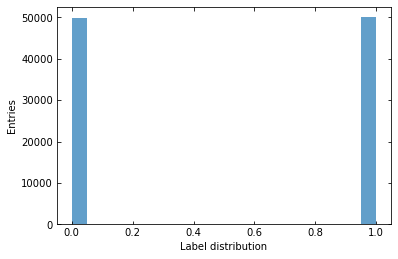

In [26]:
# distribution of truth labels
plot_hist(labels, xlabel="Label distribution").show()

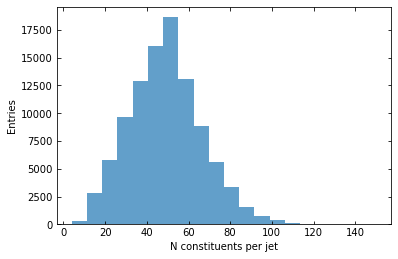

In [27]:
# number of constituents per jet
# remember, missing constituents are filled with zeros, so we take the energy value as a marker
n_c = np.count_nonzero(vectors[:, :, E], axis=1)
plot_hist(n_c, xlabel="N constituents per jet").show()

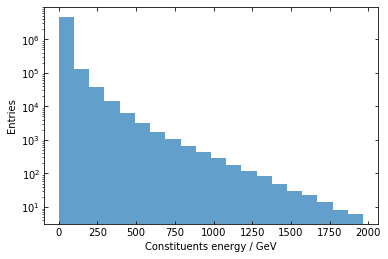

In [28]:
# energy distribution of all constituents
e_c = vectors[:, :, E].flatten()
# store a mask to remove zeros
non_zero = e_c != 0
plot_hist(e_c[non_zero], log=True, xlabel="Constituents energy / GeV").show()

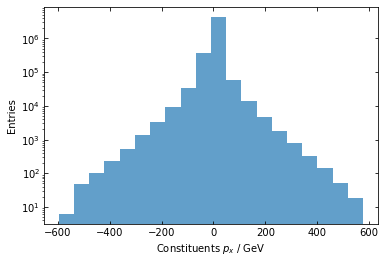

In [29]:
# px distribution of all constituents, zeros removed with the mask defined above
px_c = vectors[:, :, PX].flatten()
plot_hist(px_c[non_zero], log=True, xlabel="Constituents $p_x$ / GeV").show()

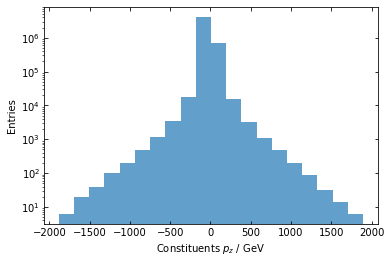

In [30]:
# pz distribution of all constituents
pz_c = vectors[:, :, PZ].flatten()
plot_hist(pz_c[non_zero], log=True, xlabel="Constituents $p_z$ / GeV").show()

# Training

In [31]:
# first, we define a preprocessing function that (e.g.) takes the
# constiuents and returns an other representation of them
# in this case, we select only the first 120 constituents and
# flatten the resulting array from (..., 120, 4) to (..., 480,)
def preprocess_constituents(constituents):
    return constituents[:, :120].reshape((-1, 480))

In [32]:
# also, for the training we need to convert the label to a "one-hot" representation
# 0. -> [1., 0.]
# 1. -> [0., 1.]
def labels_to_onehot(labels):
    labels = labels.astype(np.int32)
    onehot = np.zeros((labels.shape[0], labels.max() + 1), dtype=np.float32)
    onehot[np.arange(labels.shape[0]), labels] = 1
    return onehot

In [33]:
# define the model generating function
# - 4 hidden layers
# - 128 units each
# - tanh activation
# - 2 output units with softmax activation
# (applies exp() to outputs and normalizes sum of all outputs to 1)
def create_model():
    x = tf.keras.Input(shape=(480,))
    a1 = tf.keras.layers.Dense(128, use_bias=True, activation="tanh")(x)
    a2 = tf.keras.layers.Dense(128, use_bias=True, activation="tanh")(a1)
    a3 = tf.keras.layers.Dense(128, use_bias=True, activation="tanh")(a2)
    a4 = tf.keras.layers.Dense(128, use_bias=True, activation="tanh")(a3)
    y = tf.keras.layers.Dense(2, use_bias=True, activation="softmax")(a4)
    return tf.keras.Model(inputs=x, outputs=y, name="toptagging")

In [34]:
# create the actual model
model = create_model()
model.summary()

Model: "toptagging"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 480)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               61568     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 111,362
Trainable params: 111,362
Non-trainable params: 0
__________________________________________________

In [36]:
# load more training, and also validation data
vectors_train, labels_train = load_data("train", stop_file=6)
vectors_valid, labels_valid = load_data("valid", stop_file=3)

# run the preprocessing
vectors_train = preprocess_constituents(vectors_train)
vectors_valid = preprocess_constituents(vectors_valid)

# create one-hot labels
labels_train = labels_to_onehot(labels_train)
labels_valid = labels_to_onehot(labels_valid)

In [37]:
# compile the model
# this means that the internal computational graph structure is built,
# the loss function (the function that provides the feedback by comparing
# expected and predicted result, more on that later), and metrics are
# registered that are shown during the training
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

In [39]:
# start the training for 5 epochs (running through all data 5 times)
model.fit(
    vectors_train,
    labels_train,
    batch_size=200,
    epochs=20,
    # callbacks=[llp.PlotLossesKerasTF(outputs=[llp.outputs.MatplotlibPlot(cell_size=(4, 2))])],
)

Epoch 1/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.6515 - accuracy: 0.7004
Epoch 2/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.6483 - accuracy: 0.7063
Epoch 3/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.6472 - accuracy: 0.7081
Epoch 4/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.6472 - accuracy: 0.7083
Epoch 5/20
1500/1500 [==============================] - 13s 8ms/step - loss: 0.6472 - accuracy: 0.7084
Epoch 6/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.6470 - accuracy: 0.7089
Epoch 7/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.6473 - accuracy: 0.7082
Epoch 8/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.6467 - accuracy: 0.7097
Epoch 9/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.6467 - accuracy: 0.7094 1s - loss:
Epoch 10/20
1500/1500 [==============================] - 12s 8

In [40]:
# evaluate all training and validation data again for ruther study
predictions_train = model.predict(vectors_train)
predictions_valid = model.predict(vectors_valid)

In [41]:
# determine the accuracy
def calculate_accuracy(labels, predictions):
    # while the labels (NumPy array) are one-hot encoded,
    # each prediction (TF tensor) consists of two numbers whose sum is 1,
    # so we interpret the prediction to be the signal when the second value (index 1) is > 0.5
    # hence, we can use argmax
    predicted_top = np.argmax(predictions, axis=-1) == 1
    labels_top = labels[:, 1] == 1
    return (predicted_top == labels_top).mean()

In [42]:
acc_train = calculate_accuracy(labels_train, predictions_train)
acc_valid = calculate_accuracy(labels_valid, predictions_valid)

print(f"train accuracy: {acc_train:.4f}")
print(f"valid accuracy: {acc_valid:.4f}")

train accuracy: 0.7127
valid accuracy: 0.7140


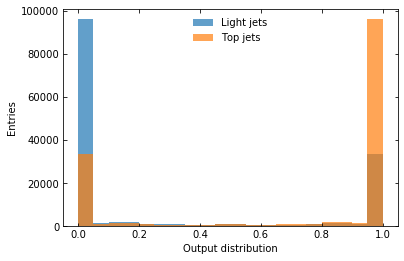

In [43]:
plot_hist(
    (predictions_valid[labels_valid == 0], predictions_valid[labels_valid == 1]),
    names=("Light jets", "Top jets"),
    xlabel="Output distribution",
).show()